In [1]:
%pylab inline

import bilby
import lal
import lalsimulation as ls
from pycbc.waveform.generator import TDomainMassSpinRingdownGenerator, FDomainMassSpinRingdownGenerator
import fisher_matrix as fm
from scipy import fftpack
from imp import reload
from astropy import units as u, constants as c
from scipy.optimize import brentq

Populating the interactive namespace from numpy and matplotlib


In [2]:
def add_default_units(quant,unit):
    if type(quant) == u.quantity.Quantity:
        return quant
    else:
        return quant*unit

In [3]:
def hp_hx_ringdown_lal(mfinal,afinal,mfrac,dist,l=2,m=2,
                       incl=0,azim=0,delta_T=1/4096,T_max=0.1):

    mfinal = add_default_units(mfinal,u.solMass)
    dist = add_default_units(dist,u.Mpc)

    ## God knows why LAL uses SI, but whatevs
    mfinal = mfinal.to(u.kg).value
    dist = dist.to(u.m).value
    
    epoch = lal.LIGOTimeGPS()
    hplus_lal, hcross_lal = ls.SimBlackHoleRingdown(
        epoch,azim,delta_T,mfinal,afinal,mfrac,dist,incl,l,m)

    times_lal = np.array([i*hplus_lal.deltaT for i in range(hplus_lal.data.length)])
    return hplus_lal.data.data, hcross_lal.data.data, times_lal

In [6]:
def hp_hx_ringdown_pycbc(mfinal,afinal,mfrac,dist,l=2,m=2,
                       incl=0,azim=0,delta_T=1/4096,T_max=0.1):

    generator = TDomainMassSpinRingdownGenerator(variable_args=['final_mass',
                    'final_spin','amp220','phi220'], lmns=['201'],
                    delta_t=delta_T, t_lower=0., t_final=T_max)
    
    hplus, hcross = generator.generate(final_mass=mfinal, final_spin=afinal,inclination=incl,
                           amp220=5e-21, amp200=1./10, phi220=40, phi200=0.)

    times = np.array([i*hplus.delta_t for i in range(hplus.data.size)])
    
    return np.array(hplus.data.data), np.array(hcross.data.data), times

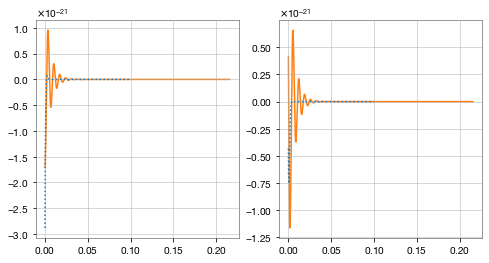

In [7]:
reload(fm)

subplots(1,2,figsize=(8,4))
ax1 = subplot(121)
ax2 = subplot(122)

mf, af, dist, mfrac = 100, 0.69, 400, 0.01
incl, azim = 0.5, 0.3
l, m = 2,1
delta_T, T_max = 1./4096, 0.1

hp,hx,times = fm.hp_hx_ringdown_time_domain(
    mf, af, mfrac,inclination=incl,dist=dist,phi0=azim,delta_T=delta_T,T_max=T_max,n=4,l=l,m=m)

ax1.plot(times,-4*pi*hp,zorder=10,ls=':')
ax2.plot(times,-4*pi*hx,zorder=10,ls=":")

hp,hx,times = hp_hx_ringdown_lal(mfinal=mf,afinal=af,mfrac=mfrac,dist=dist,l=l,m=m,
                       incl=incl,azim=azim,delta_T=delta_T,T_max=T_max)

ax1.plot(times,-hp)
ax2.plot(times,-hx)

# hp,hx,times = hp_hx_ringdown_pycbc(mfinal=mf,afinal=af,mfrac=mfrac,dist=dist,l=l,m=m,
#                        incl=incl,azim=azim,delta_T=delta_T,T_max=T_max)

# plot(times,hp*5)



In [131]:
reload(fm)

mf, af, dist, mfrac = 40, 0.69, 400, 0.01
incl = 1.2
l, m = 2,2
delta_T, T_max = 1./8192/32, 0.035

find_phi_hp = lambda phi: fm.hp_hx_ringdown_time_domain(
    mf, af, mfrac,inclination=incl,dist=dist,phi0=phi,delta_T=delta_T,T_max=T_max,l=l,m=m)[0][0]
azim_p = brentq(find_phi_hp,0,np.pi/m)

find_phi_hx = lambda phi: fm.hp_hx_ringdown_time_domain(
    mf, af, mfrac,inclination=incl,dist=dist,phi0=phi,delta_T=delta_T,T_max=T_max,l=l,m=m)[1][0]
azim_x = brentq(find_phi_hx,0,np.pi/m)

(1.1407301503846232-0.011598456368291151j) (0.025713123609241908-0.0011531439392089011j)
(1.1407301503846232-0.011598456368291151j) (0.025713123609241908-0.0011531439392089011j)


/Users/carl/opt/anaconda3/envs/bilby/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in true_divide
/Users/carl/opt/anaconda3/envs/bilby/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide


(-0.0002563797223648095, 172.63908859684952, -0.0002563797223648095, 1.0)

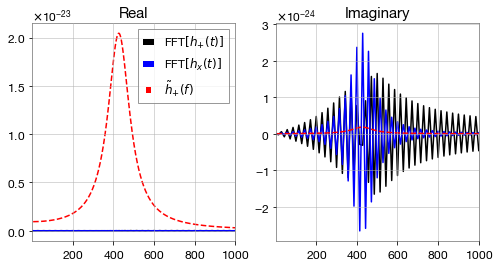

In [117]:
reload(fm)

subplots(1,2,figsize=(8,4))
ax1 = subplot(121)
ax2 = subplot(122)

azim_p = 0
azim_x = pi/2

hp,_,times = fm.hp_hx_ringdown_time_domain(
    mf, af, mfrac,inclination=incl,dist=dist,phi0=azim_p,delta_T=delta_T,T_max=T_max,l=l,m=m)
_,hx,times = fm.hp_hx_ringdown_time_domain(
    mf, af, mfrac,inclination=incl,dist=dist,phi0=azim_x,delta_T=delta_T,T_max=T_max,l=l,m=m)

hp = hstack([-hp[:1:-1],hp])
hx = hstack([-hx[:1:-1],hx])

times = hstack([-times[:1:-1],times]) + times[-1]

num_samples = len(times)

delta_T = abs(times[1] - times[0])
hp_f = fftpack.fft(hp)
hx_f = fftpack.fft(hx)

freqs = linspace(0., 1/(2*delta_T),int(num_samples/2))
ax1.plot(freqs,2/num_samples * (hp_f[:num_samples//2]).real,color='black')
ax1.plot(freqs,2/num_samples * (hx_f[:num_samples//2]).real,color='blue')

ax2.plot(freqs,2/num_samples * (hp_f[:num_samples//2]).imag,color='black')
ax2.plot(freqs,2/num_samples * (hx_f[:num_samples//2]).imag,color='blue')

hplus_tilda,_,freqs = fm.hp_hx_ringdown(mf,af,mfrac,incl,dist,phi0=azim_p,l=l,m=m)
_,hcross_tilda,freqs = fm.hp_hx_ringdown(mf,af,mfrac,incl,dist,phi0=azim_p,l=l,m=m)

thing=200

amp_ratio_p = (max((hplus_tilda).real)/max(2/num_samples * (hp_f[:num_samples//2]).real))
amp_ratio_x = (max((hcross_tilda).real)/max(2/num_samples * (hx_f[:num_samples//2]).real))
ax1.plot(freqs,(hplus_tilda).real*thing,color='r',linestyle='--')
# ax1.plot(freqs,(hcross_tilda).real*thing,color='orange',linestyle='--')

amp_ratio_p = (max((hplus_tilda).imag)/max(2/num_samples * (hp_f[:num_samples//2]).imag))
amp_ratio_x = (max((hcross_tilda).imag)/max(2/num_samples * (hx_f[:num_samples//2]).imag))
ax2.plot(freqs,(hplus_tilda).imag*thing,color='r',linestyle='--')
# ax2.plot(freqs,(hcross_tilda).imag*thing,color='orange',linestyle='--')

ax1.set_xlim(1,1000)
ax2.set_xlim(1,1000)

ax1.legend((r"FFT$[h_{+}(t)]$",r"FFT$[h_x(t)]$",r"$\tilde{h}_{+}(f)$",r"$\tilde{h}_x(f)$]"))

ax1.set_title("Real",fontsize=15)
ax2.set_title("Imaginary",fontsize=15)

ratio1,ratio2,ratio3,ratio4 = (median(hp_f.real/hp_f.imag),
                               median(hplus_tilda.real/hplus_tilda.imag),
                               median(hp_f.real/hp_f.imag),
                               max(hplus_tilda.imag)/max(hcross_tilda.imag))

ratio1,ratio2,ratio3,ratio4

(0.6754490372008947+0.002376412897832445j) (0.1234012374474211-0.003967310264287309j)
(0.6754490372008947+0.002376412897832445j) (0.1234012374474211-0.003967310264287309j)


/Users/carl/opt/anaconda3/envs/bilby/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
/Users/carl/opt/anaconda3/envs/bilby/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in true_divide


(-0.00025637643579271235,
 -194.6785543734748,
 -0.00025637643579271235,
 -1.1609407626511657e-05)

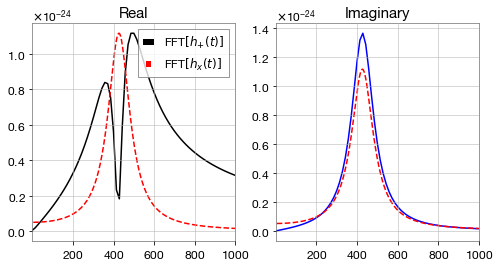

In [135]:
reload(fm)

subplots(1,2,figsize=(8,4))
ax1 = subplot(121)
ax2 = subplot(122)

hp,_,times = fm.hp_hx_ringdown_time_domain(
    mf, af, mfrac,inclination=incl,dist=dist,phi0=azim_p,delta_T=delta_T,T_max=T_max,l=l,m=m)
_,hx,times = fm.hp_hx_ringdown_time_domain(
    mf, af, mfrac,inclination=incl,dist=dist,phi0=azim_x,delta_T=delta_T,T_max=T_max,l=l,m=m)

hp = hstack([-hp[:1:-1],hp])
hx = hstack([-hx[:1:-1],hx])

times = hstack([-times[:1:-1],times]) + times[-1]

num_samples = len(times)

delta_T = abs(times[1] - times[0])
hp_f = fftpack.fft(hp)
hx_f = fftpack.fft(hx)

freqs = linspace(0., 1/(2*delta_T),int(num_samples/2))
ax1.plot(freqs,2/num_samples * np.abs(hp_f[:num_samples//2]),color='black')
ax2.plot(freqs,2/num_samples * np.abs(hx_f[:num_samples//2]),color='blue')

hplus_tilda,_,freqs = fm.hp_hx_ringdown(mf,af,mfrac,incl,dist,phi0=azim_p,l=l,m=m)
_,hcross_tilda,freqs = fm.hp_hx_ringdown(mf,af,mfrac,incl,dist,phi0=azim_p,l=l,m=m)

thing=200


amp_ratio_p = (max(np.abs(hplus_tilda))/max(2/num_samples * np.abs(hp_f[:num_samples//2])))
amp_ratio_x = (max(np.abs(hcross_tilda))/max(2/num_samples * np.abs(hx_f[:num_samples//2])))
ax1.plot(freqs,np.abs(hplus_tilda)/amp_ratio_p,color='r',linestyle='--')

ax2.plot(freqs,np.abs(hplus_tilda)/amp_ratio_p,color='r',linestyle='--')

ax1.set_xlim(1,1000)
ax2.set_xlim(1,1000)

ax1.legend((r"FFT$[h_{+}(t)]$",r"FFT$[h_x(t)]$",r"$\tilde{h}_{+}(f)$",r"$\tilde{h}_x(f)$]"))

ax1.set_title("Real",fontsize=15)
ax2.set_title("Imaginary",fontsize=15)

ratio1,ratio2,ratio3,ratio4 = (median(hp_f.real/hp_f.imag),
                               median(hplus_tilda.real/hplus_tilda.imag),
                               median(hp_f.real/hp_f.imag),
                               max(hplus_tilda.imag)/max(hcross_tilda.imag))

ratio1,ratio2,ratio3,ratio4

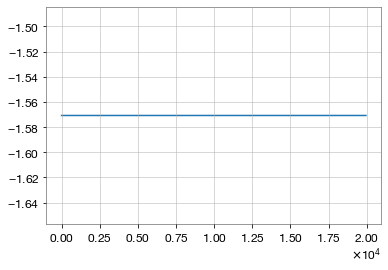

In [112]:
plot(arctan(hplus_tilda.imag/hplus_tilda.real))

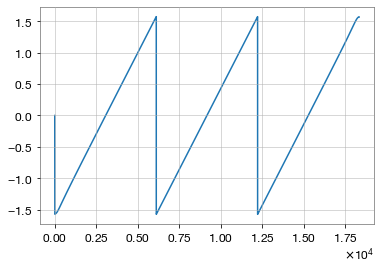

In [103]:
plot(arctan(hp_f.imag/hp_f.real))

In [48]:
reload(fm)

incl = 1.5
for mm in [1,2]:
    l = 2
    delta_T, T_max = 1./8192/32, 0.035
    mf, af, dist, mfrac = 40, 0.69, 400, 0.01

    find_phi_hp = lambda phi: fm.hp_hx_ringdown_time_domain(
        mf, af, mfrac,inclination=incl,dist=dist,phi0=phi,delta_T=delta_T,T_max=T_max,l=l,m=m)[0][0]
    azim_p = brentq(find_phi_hp,0,np.pi/m)

    find_phi_hx = lambda phi: fm.hp_hx_ringdown_time_domain(
        mf, af, mfrac,inclination=incl,dist=dist,phi0=phi,delta_T=delta_T,T_max=T_max,l=l,m=m)[1][0]
    azim_x = brentq(find_phi_hx,0,np.pi/m)


    hp,_,times = fm.hp_hx_ringdown_time_domain(
        mf, af, mfrac,inclination=incl,dist=dist,phi0=azim_p,delta_T=delta_T,T_max=T_max,l=l,m=m)
    _,hx,times = fm.hp_hx_ringdown_time_domain(
        mf, af, mfrac,inclination=incl,dist=dist,phi0=azim_x,delta_T=delta_T,T_max=T_max,l=l,m=m)

    hp = hstack([-hp[:1:-1],hp])
    hx = hstack([-hx[:1:-1],hx])

    times = hstack([-times[:1:-1],times]) + times[-1]

    num_samples = len(times)

    delta_T = abs(times[1] - times[0])
    hp_f = fftpack.fft(hp)
    hx_f = fftpack.fft(hx)
    freqs_T = linspace(0., 1/(2*delta_T),int(num_samples/2))

    for aa in [1,1j]:
        for bb in [-1,1]:
            for cc in [-1,1]:
                for dd in [-1,1]:
                    for ee in [-1,1]:
                        for ff in [-1,1]:
                            for gg in [-1,1]:
                                for hh in [-1,1]:
                                    for ii in [-1,1]:
                                        for jj in [-1,1]:

                                            hplus_tilda,hcross_tilda,freqs = fm.hp_hx_ringdown(mf,af,mfrac,incl,dist,phi0=azim_p,l=l,m=m,aa=aa,bb=bb,cc=cc,dd=dd,ee=ee,ff=gg,gg=gg,hh=hh,ii=ii,jj=jj)
                                            _,hcross_tilda,freqs = fm.hp_hx_ringdown(mf,af,mfrac,incl,dist,phi0=azim_x,l=l,m=m,aa=aa,bb=bb,cc=cc,dd=dd,ee=ee,ff=gg,gg=gg,hh=hh,ii=ii,jj=jj)

                                            ratio1,ratio2,ratio3,ratio4 = (max(hp_f.real)/max(hx_f.real),
                                                                           max(hplus_tilda.real)/max(hcross_tilda.real),
                                                                           max(hp_f.imag)/max(hx_f.imag),
                                                                           max(hplus_tilda.imag)/max(hcross_tilda.imag))

                                            if isclose(ratio1,ratio2,rtol=0.2) & isclose(ratio3,ratio4,rtol=0.2):

                                                name = ('m='+str(m)+'.'+str(aa)+'.'+str(bb)+'.'+str(cc)+'.'+str(dd)+'.'+str(ee)+'.'+str(ff)+'.'+
                                                        str(gg)+'.'+str(hh)+'.'+str(ii)+'.'+str(jj)+'.png')


                                                clf()
                                                subplots(1,2,figsize=(8,4))
                                                ax1 = subplot(121)
                                                ax2 = subplot(122)


                                                ax1.plot(freqs_T,2/num_samples * (hp_f[:num_samples//2]).real,color='black')
                                                ax1.plot(freqs_T,2/num_samples * (hx_f[:num_samples//2]).real,color='blue')
                                                ax2.plot(freqs_T,2/num_samples * (hp_f[:num_samples//2]).imag,color='black')
                                                ax2.plot(freqs_T,2/num_samples * (hx_f[:num_samples//2]).imag,color='blue')

                                                amp_ratio_p = (max((hplus_tilda).real)/max(2/num_samples * (hp_f[:num_samples//2]).real))
                                                amp_ratio_x = (max((hcross_tilda).real)/max(2/num_samples * (hx_f[:num_samples//2]).real))
                                                ax1.plot(freqs,(hplus_tilda).real/amp_ratio_p,color='r',linestyle='--')
                                                ax1.plot(freqs,(hcross_tilda).real/amp_ratio_x,color='orange',linestyle='--')

                                                amp_ratio_p = (max((hplus_tilda).imag)/max(2/num_samples * (hp_f[:num_samples//2]).imag))
                                                amp_ratio_x = (max((hcross_tilda).imag)/max(2/num_samples * (hx_f[:num_samples//2]).imag))
                                                ax2.plot(freqs,(hplus_tilda).imag/amp_ratio_p,color='r',linestyle='--')
                                                ax2.plot(freqs,(hcross_tilda).imag/amp_ratio_x,color='orange',linestyle='--')

                                                ax1.set_xlim(1,1000)
                                                ax2.set_xlim(1,1000)

                                                ax1.legend((r"FFT$[h_{+}(t)]$",r"FFT$[h_x(t)]$",r"$\tilde{h}_{+}(f)$",r"$\tilde{h}_x(f)$]"))

                                                ax1.set_title("Real",fontsize=15)
                                                ax2.set_title("Imaginary",fontsize=15)
                                                savefig(name)


False

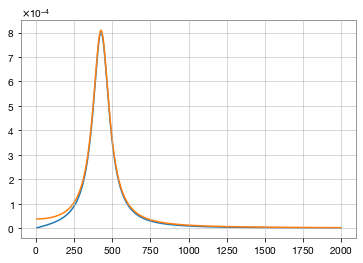

In [38]:
phip = 0.5
phix = 0.5

plot(freqs,abs(s_nlm*b_plus + s_nlm_conj*b_minus))
plot(freqs,abs(-1j*(s_nlm*b_plus - s_nlm_conj*b_minus)))

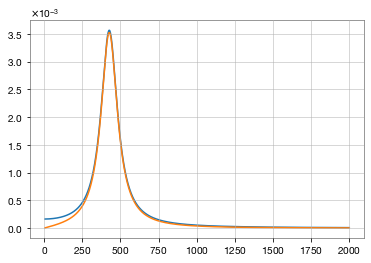

In [120]:
reload(fm)

b_plus,b_minus,s_nlm,s_nlm_conj,freqs = fm.hp_hx_ringdown(
    mf,af,mfrac,0.5,dist,phi0=azim_p,l=l,m=m)
hx = (-1j*(b_plus-b_minus)*(s_nlm.real+s_nlm_conj.real) + (b_plus+b_minus)*(s_nlm.imag+s_nlm_conj.imag))
plot(freqs,abs(hx))
hx = (-1j*(b_plus-b_minus)*(s_nlm.real+s_nlm_conj.real) + (-b_plus+b_minus)*(s_nlm.imag+s_nlm_conj.imag))
plot(freqs,abs(hx))

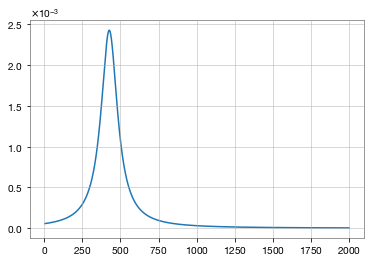

In [114]:
plot(freqs,b_minus)